(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [27]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob
# Import package to save chains into memory
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains
import Zygote

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of adaptive mutants fitness

## The fitness model

`[explanation here]`

## Loading the data

Let's begin by loading the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programing language that `Turing.jl` encodes.

`[explanation here]`

Let's define the model using the @model macro from `Turing.jl`

In [3]:
Turing.@model function fitness_mutants(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through neutral lineages
    for j = 1:size(logf_neutral, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_neutral[:, j]) .& .!isnan.(logf_neutral[:, j])
        # Sample
        logf_neutral[idx, j] ~ Turing.MvNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for

    # Adaptive mutants fitness
    
     # Loop through mutants lineages
     for j = 1:size(logf_mut, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_mut[:, j]) .& .!isnan.(logf_mut[:, j])
        # Sample
        logf_mut[idx, j] ~ Turing.MvNormal(
            s̲ₘ[j] .- s̲ₜ[idx], 
            LinearAlgebra.I(sum(idx)) .* (σ̲ₘ[j] .^2)
        )
    end # for

    return logf_mut, logf_neutral
end # @model function

fitness_mutants (generic function with 2 methods)

Let's now extract the data.

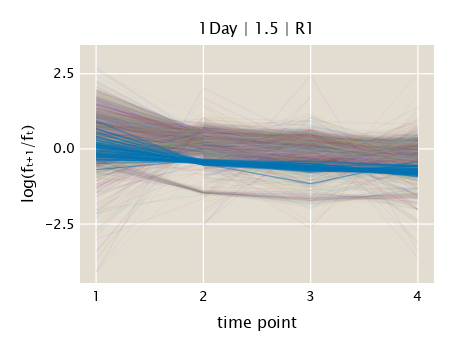

In [4]:
# Define information for data to extract
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"
# batch = "Batch1"
# hub = "1Day"
# perturbation = "28"
# rep = "R1"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Let's extract the data and put it into a convenient format.

In [5]:
# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

4×56 Matrix{Float32}:
 -0.34545   -0.349183  -0.0599262  …   0.142053   0.0903559  -0.159051
 -0.439573  -0.430029  -0.386549      -0.466767  -0.404325   -0.335645
 -0.779961  -0.613287  -0.596358      -0.48619   -0.580775   -0.574143
 -0.579903  -0.866741  -0.768193      -0.916034  -0.819359   -0.843799

Now, we are ready to test the model. Let's run the inference for a few of the
strains.

In [6]:
Random.seed!(42)

# Define model
model = fitness_mutants(
    logf_mut[:, 1:5], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    Float32(5.0),
    Float32(1.0),
);

# Suppress warning outputs
# Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        1_000, 
        3, 
        progress=false
    )
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       s̲ₘ[1]    0.9500    0.2561     0.0047    0.0062   1378.2948    1.0010    ⋯
       s̲ₘ[2]   -0.0115    0.8340     0.0152    0.0199   2020.2916    1.0003    ⋯
       s̲ₘ[3]    0.3049    0.6303     0.0115    0.0135   2152.8294    1.0010    ⋯
       s̲ₘ[4]    0.6902    0.5044     0.0092    0.0093   2160.9325    0.9995    ⋯
       s̲ₘ[5]    0.7405    0.3361     0.0061    0.0072   2663.9497    0.9996    ⋯
       σ̲ₘ[1]    0.4500    0.2597     0.0047    0.0068   1352.1322    0.9992    ⋯
       σ̲ₘ[2]    1.6385    0.4291     0.0078    0.0102   2297.9039    1.0001    ⋯
       σ̲ₘ[3]    1.2110    0.3998     0.0073    0.0074   2601.4335    0.9996    ⋯
       σ̲ₘ[4]    0.9643    0.3566     0.0065    0.0077   2197.8645    0.9995    ⋯
       σ̲ₘ[5]    0.6126    0.3002     0.0055    0.0059   1991.4104    0.9997    

Let's look at the traces for each of the walkers on each parameter.

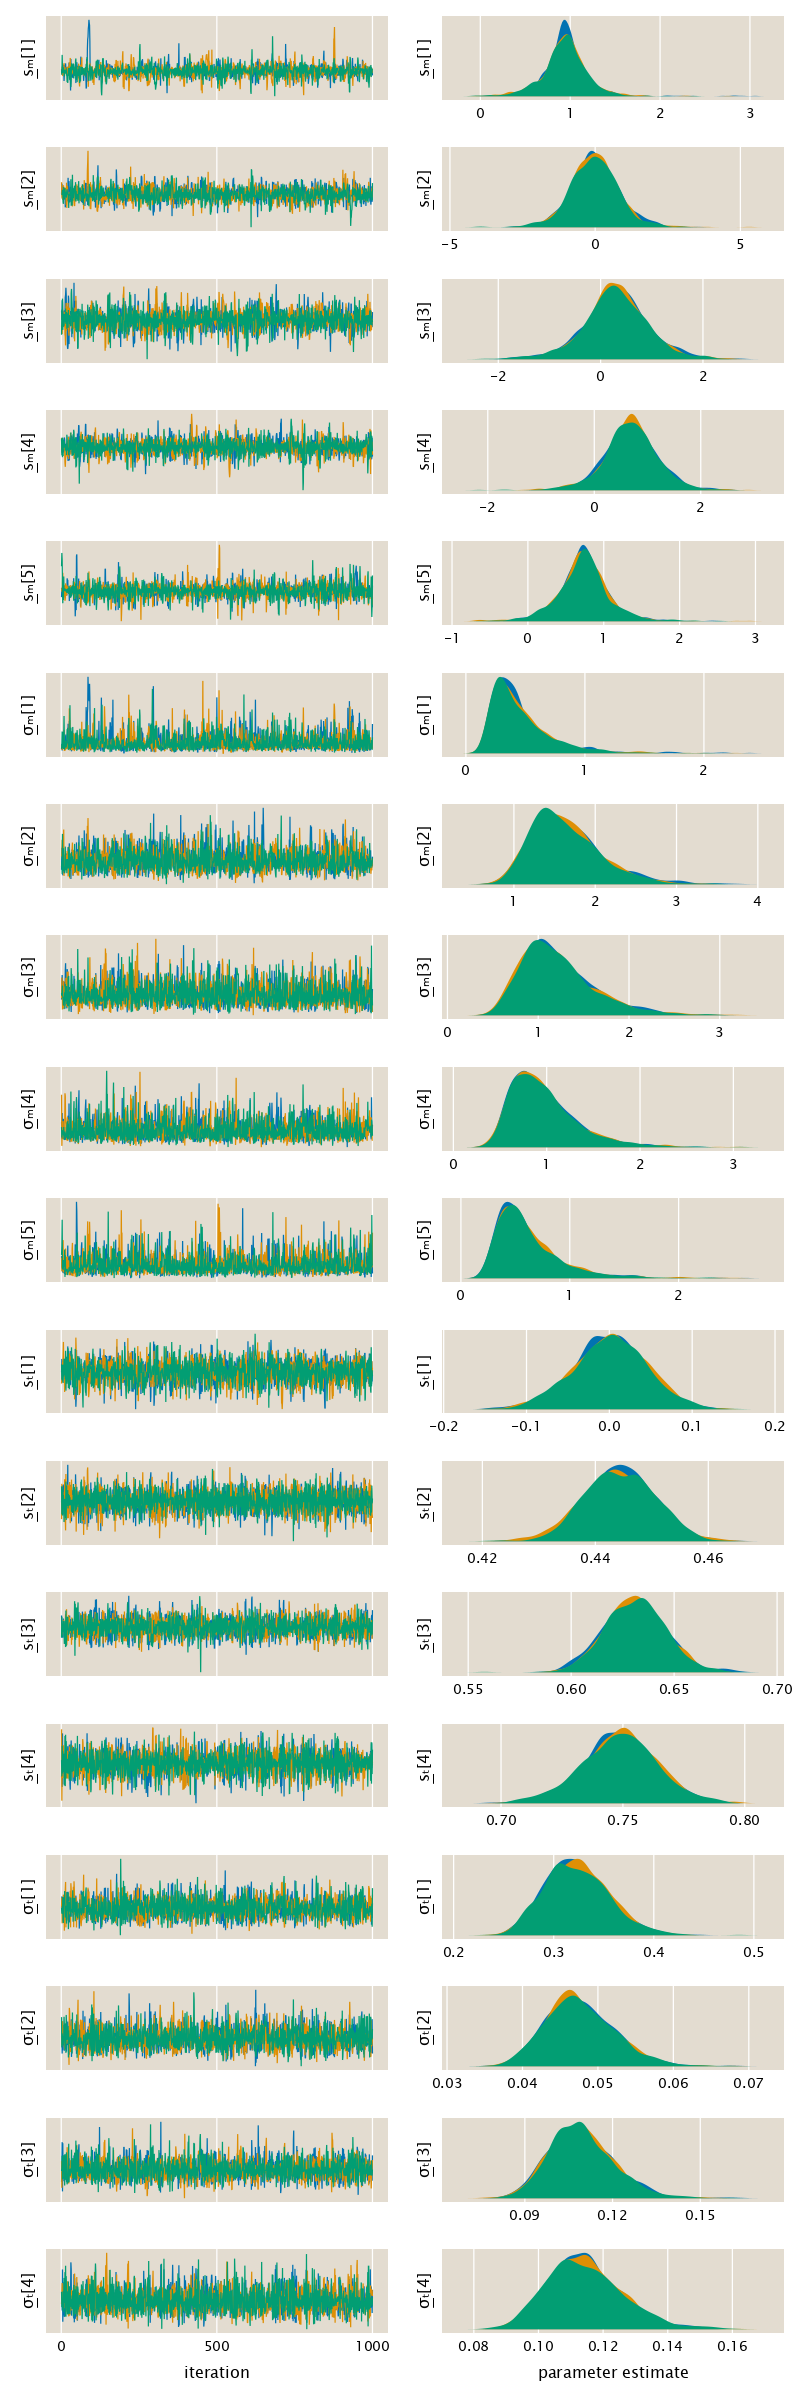

In [7]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

# Vectorized model

In [33]:
Turing.@model function fitness_mutants_vectorized(
    df_mut,
    df_neutral,
    n_time, 
    n_mut,
    σ_sm, 
    σ_σm, 
    σ_st, 
    σ_σt
)
    ## Prior
    
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), n_time)
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σt); lower=0.0 + eps()), n_time
    )

    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), n_mut)
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist( 
        Turing.truncated(Turing.Normal(0, σ_σm); lower=0.0 + eps()), n_mut
    )
    
    ## Likelihood

    # Population mean fitness
    logf_neutral_vec ~ Turing.MvNormal(
        -s̲ₜ[df_neutral.time], 
        LinearAlgebra.Diagonal(σ̲ₜ[df_neutral.time]  .^2)
    )
   
    # Adaptive mutants fitness
    logf_mut_vec ~ Turing.MvNormal(
        s̲ₘ[df_mut.bc_idx] .- s̲ₜ[df_mut.time],
        LinearAlgebra.Diagonal(σ̲ₘ[df_mut.bc_idx] .^2)
    )
    
    return logf_mut, logf_neutral
end # @model function

fitness_mutants_vectorized (generic function with 2 methods)

In [29]:
# Define information for data to extract
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for (i, d) in enumerate(data_group)
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral),
            :bc_idx .=> i
        )
    )
end # for

first(data_log, 5)

Row,barcode,time,logf,neutral,bc_idx
,String,Int64,Float64,Bool,Int64
1,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,1,1.3656,false,1
2,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,2,0.344634,false,1
3,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,3,0.138836,false,1
4,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,4,0.1088,false,1
5,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,1,-2.88439,false,2


In [30]:
Random.seed!(42)

# Extract data
df_mut = data_log[
    .!(data_log.neutral) .& .!isinf.(data_log.logf) .& .!isnan.(data_log.logf),
[:time, :logf, :bc_idx]]

df_neutral = data_log[
    (data_log.neutral) .& .!isinf.(data_log.logf) .& .!isnan.(data_log.logf),
[:time, :logf, :bc_idx]];

In [37]:
# Switch Automatic differentiation backend
Turing.setadbackend(:zygote)

# Define number of mutants
n_mut = 1000

# Define model
model = fitness_mutants_vectorized(
    df_mut[1:n_mut, :], 
    df_neutral, 
    length(unique(data_log.time)), 
    n_mut, 
    5.0, 
    1.0,
    5.0,
    1.0,
);

# Suppress warning outputs
# Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        # Turing.MCMCThreads(),
        10, 
        # 4, 
        progress=false
    )
# end

# Print summary stats
Turing.summarystats(chain)

## Cauchy 

In [ ]:
Turing.@model function fitness_mutants_cauchyprior(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Cauchy(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Cauchy(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through neutral lineages
    for j = 1:size(logf_neutral, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_neutral[:, j])
        # Sample
        logf_neutral[idx, j] ~ Turing.MvNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for

    # Adaptive mutants fitness
    
     # Loop through mutants lineages
     for j = 1:size(logf_mut, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_mut[:, j])
        # Sample
        logf_mut[idx, j] ~ Turing.MvNormal(
            s̲ₘ[j] .- s̲ₜ[idx], 
            LinearAlgebra.I(sum(idx)) .* (σ̲ₘ[j] .^2)
        )
    end # for

    return logf_mut, logf_neutral
end # @model function

In [ ]:
# Define information for data to extract
batch = "Batch1"
hub = "1Day"
perturbation = "28"
rep = "R1"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

In [ ]:
Random.seed!(42)

# Define model
model = fitness_mutants_cauchyprior(
    logf_mut[:, 1:10], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    Float32(5.0),
    Float32(1.0),
);

# Suppress warning outputs
Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        2_000, 
        3, 
        progress=false
    )
end

# Print summary stats
Turing.summarystats(chain)

In [ ]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

# Two-step inference

The inference of the entire dataset with > 4000 mutants does not scale properly,
even though, sampling for a few mutants is almost instantaneous. But we can take
advantage of the structure of our problem.